# Let's Explore Some Telco Churn Data

Data can be found here WA_Fn-UseC_-Telco-Customer-Churn.csv: https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv

# What’s in the Telco Customer Churn data set?
This data set provides info to help you predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

A telecommunications company is concerned about the number of customers leaving their landline business for cable competitors. They need to understand who is leaving. Imagine that you’re an analyst at this company and you have to find out who is leaving and why.

The data set includes information about:
* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents



# Choose interactive or inline plotting

In [1]:
#%matplotlib notebook
%matplotlib inline

In [2]:
!pwd

/data/mldl-101/lab2-watson-churn-outlier


In [3]:
import pandas as pd
import numpy as np
# Added to support multiple environments
#!wget https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv
nimbix = True
if(nimbix) :
    churn = pd.read_csv('/data/mldl-101/lab2-watson-churn-outlier/WA_Fn-UseC_-Telco-Customer-Churn.csv')
else :
    churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Handy Utilities

In [4]:
from itertools import compress
from churnlab_utils import pdutil_describeItemRange
from churnlab_utils import pdutil_factorize
from churnlab_utils import pdutil_OneHotEncode
from churnlab_utils import pdutil_dbscan
from churnlab_utils import plot_confusion_matrix
from churnlab_utils import Classifier
   
# Print the pandas schema
churn.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

# Some Cleaning Required
TotalCharges is an object rather than a float64. We will convert it to float64 and **force any non numeric items** to be repalced with the **mean**.

Other methods might interpolate a missing value using a linear interpolation, or usse the max value, or in some cases drop these instances - it all depends on the data.

In [5]:
churn[['TotalCharges']] = churn[['TotalCharges']].apply(pd.to_numeric, errors='coerce') 
churn["TotalCharges"].fillna(churn["TotalCharges"].mean(), inplace=True)

# Describe the Range of Values in each Column
The is an important step in understanding your data. Not only should I have an understanding of the size and shape of my data, the number of rows and columns, but also how many unique values each column may take on. This is important for upcoming steps where we encode the data for consumption by a model. knowing how many possible values can influence the choice of encodig such one-hot-encoding verus binning for example. For classification purposes, the categorical values (most of the entirety of this table) have 2 to 4 possible values and might be candidates for one-hot-encoding or similar encodings.  But MonthlyCharges and TotalCharges, if manipulated at all, might benefit from binning, since this is more of a continous varibale and not categorical.

In [6]:
pdutil_describeItemRange(churn)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7043,2,2,2,2,73,2,3,3,3,...,3,3,3,3,3,2,4,1585,6531,2


## Explore Churn Data
* the number of rows, 
* the number of columns,
* any descriptive statistics

## Separate Categorical from Numeric Data for Further Processing
* numeric data for now will be kept in a separate dataframe
* categorical data will be in its own dataframe for be transformed into values in kind of pipeline

In [7]:
# here are the columns which are categorical
churn_cat_col = [key for key in dict(churn.dtypes) if dict(churn.dtypes)[key] in ['object']]
# here are the columns which are numeric
churn_num_col = [key for key in dict(churn.dtypes) if dict(churn.dtypes)[key] in ['float64', 'int64']]
#create a dataframe to hold categorical data
churn_cat = churn[churn_cat_col]
#create a dataframe to hold numeric data
churn_num = churn[churn_num_col]


In [8]:
# display first few rows of numerical data to get a feel for them
churn_num.head()

,SeniorCitizen,MonthlyCharges,tenure,TotalCharges
0,0,29.85,1,29.85
1,0,56.95,34,1889.50
2,0,53.85,2,108.15
3,0,42.30,45,1840.75
4,0,70.70,2,151.65


In [9]:
# display first few rows of categorical data to get a feel for them
churn_cat.head()

,Churn,DeviceProtection,TechSupport,OnlineBackup,MultipleLines,gender,StreamingTV,Contract,StreamingMovies,PhoneService,PaperlessBilling,OnlineSecurity,Partner,Dependents,InternetService,PaymentMethod,customerID
0,No,No,No,Yes,No phone service,Female,No,Month-to-month,No,No,Yes,No,Yes,No,DSL,Electronic check,7590-VHVEG
1,No,Yes,No,No,No,Male,No,One year,No,Yes,No,Yes,No,No,DSL,Mailed check,5575-GNVDE
2,Yes,No,No,Yes,No,Male,No,Month-to-month,No,Yes,Yes,Yes,No,No,DSL,Mailed check,3668-QPYBK
3,No,Yes,Yes,No,No phone service,Male,No,One year,No,No,No,Yes,No,No,DSL,Bank transfer (automatic),7795-CFOCW
4,Yes,No,No,No,No,Female,No,Month-to-month,No,Yes,Yes,No,No,No,Fiber optic,Electronic check,9237-HQITU


In [10]:
churn_num.describe()

,SeniorCitizen,MonthlyCharges,tenure,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,64.761692,32.371149,2283.300441
std,0.368612,30.090047,24.559481,2265.000258
min,0.000000,18.250000,0.000000,18.800000
25%,0.000000,35.500000,9.000000,402.225000
50%,0.000000,70.350000,29.000000,1400.550000
75%,0.000000,89.850000,55.000000,3786.600000
max,1.000000,118.750000,72.000000,8684.800000


# Convert Categories to Numbers

we apply the factorize fucntion to all the categories as a first pass. We created a new dataframe here called **churn_cat_encode**

The commented out code woudl allow us to map back to the original form if needed

PaymentMethod for example will now have numeric values like 0, 1, 2, 3,...:


In [11]:
#  pd_factorize the categorical churn columns
churn_cat_encode = pdutil_factorize(churn_cat)
churn_cat_encode.head()

,Churn,DeviceProtection,TechSupport,OnlineBackup,MultipleLines,gender,StreamingTV,Contract,StreamingMovies,PhoneService,PaperlessBilling,OnlineSecurity,Partner,Dependents,InternetService,PaymentMethod,customerID
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,1,1,0,1,0,1,1,1,1,0,0,1,1
2,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,1,2
3,0,1,1,1,0,1,0,1,0,0,1,1,1,0,0,2,3
4,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,4


In [12]:
churn.groupby('TechSupport').count()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
TechSupport,,,,,,,,,,,,,,,,,,,,
No,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473
No internet service,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526
Yes,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044


In [13]:
churn_cat_encode.groupby('TechSupport').count()

,Churn,DeviceProtection,OnlineBackup,MultipleLines,gender,StreamingTV,Contract,StreamingMovies,PhoneService,PaperlessBilling,OnlineSecurity,Partner,Dependents,InternetService,PaymentMethod,customerID
TechSupport,,,,,,,,,,,,,,,,
0,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473
1,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044
2,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526


# Encode the data (OneHotEncode)
The problem with the data above is that while the data are numeric, it give arbitrary low weights to categories encoded with 0 and higher weights to others

This will probably skew our analysis. For example, PaymentMethod has values 0, 1, 2.  Do we really mean to imply that PaymentMethod=0 has no weight, but PaymentMethod=2 has twice as much weight as PaymentMethod=1?

We use OneHotEncode here to make sure each value that was used is encoded with the value 1, while the value will be 0 if that feature was not used.

**Note:** We dont want to encode categories with many unique values in it such as customerID. 

We define a funvtion to handle doing the encoding for us

Now PaymentMethod will be split into brand new columns (one for each kind of numeric value) and each cell will have either 0 or 1, kind of like a check box, indicating the feature was present or not.

We also concatenate the previous numerica columns back in to have them available for analysis after standardization.

In [14]:
# list of column name I wish to OneHotEncode
cols_OneHotEncode = ['DeviceProtection','TechSupport','OnlineBackup','MultipleLines','gender','StreamingTV','Contract','StreamingMovies','PhoneService','PaperlessBilling','OnlineSecurity','Partner','Dependents','InternetService','PaymentMethod']
# label is the column I ultimately want to predict aka Churn
label = churn_cat_encode['Churn']
# customer is the column representing the customerId
customer =  churn_cat_encode['customerID']
churn_encoded_numeric = pdutil_OneHotEncode (churn_cat_encode, [], cols_OneHotEncode)
churn_encoded_numeric = pd.concat([churn_encoded_numeric, churn_num], axis=1)  # add numeric to main df
churn_encoded_numeric.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,StreamingTV2,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges
0,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,29.85,1,29.85
1,0,1,0,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,56.95,34,1889.50
2,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,53.85,2,108.15
3,0,1,0,1,0,0,1,0,1,0,...,0,0,1,0,0,1,0,42.30,45,1840.75
4,1,0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,70.70,2,151.65


# Standardize the Data

We scale and center the data around the mean. The reason is to make sure that each column gets a fair vote in the upcoming pca.  Without scaling, a column such as total_charges, with large range of values with larger absolute magnitude could dominate in PCA and effectively become the defacto largest pca component.

In [15]:
from sklearn import preprocessing
#scale our data to zero center it
scaler = preprocessing.StandardScaler().fit(churn_encoded_numeric)
X_scaled = preprocessing.scale(churn_encoded_numeric, with_mean=True, with_std=True )   # same as (df-df.mean())/df.std(ddof=0)

## Copy Churn Column to Encoded Dataframe
This dataframe has the same number of rows as the principal components Dataframe

They are parallel with each other

This copy step may be redundant since we copied Churn to the PCA Dataframe too, but it makes plotting more convenient

In [16]:
if 'Churn' not in churn_encoded_numeric.columns:
    churn_encoded_numeric = pd.concat([churn_encoded_numeric, label], axis=1)


# Correlation Plot
Plot shows which factors are correlated with which ohers and to what degree.

Here, red means highly correlated (as in correlated with Churn being bad therefor red), blue means negatively correlated, and white means no correlation.
**Notice** A customer with more contracts, more dependents, more tenure are less likley to churn in this example.

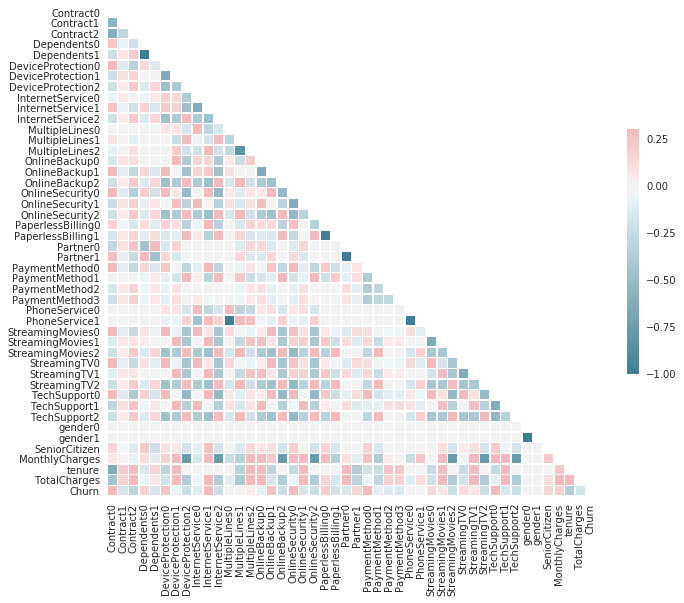

In [17]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = churn_encoded_numeric.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<h1><center>Principal Component Analysis To Analyze Bahavior</center></h1>

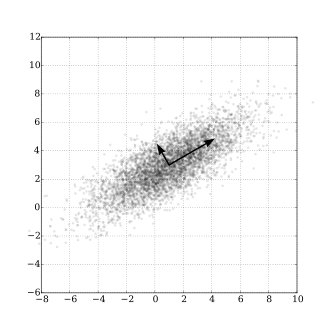

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables.




In [18]:
# display sorted eigenvalues
from sklearn.decomposition import PCA
scaler = preprocessing.StandardScaler().fit(churn_encoded_numeric.drop('Churn', axis=1))
X_scaled = preprocessing.scale(churn_encoded_numeric, with_mean=True, with_std=True )   # same as (df-df.mean())/df.std(ddof=0)
# start w n_components principal components and see how much variance that gives me
n_components = 20
# create instance of PCA (constructor)
pca = PCA(n_components=n_components)
#pca = PCA(copy=True, iterated_power='auto', n_components=n_components, random_state=None, svd_solver='auto', tol=0.0, whiten=False) 
pca.fit(X_scaled)
np_pcomps = pca.transform(X_scaled)  #get the actual principal components as vectors
print(pca.explained_variance_ratio_) 

[0.24846864 0.13513933 0.09331915 0.05528886 0.04969195 0.04352434
 0.03638109 0.03388938 0.02967938 0.02826875 0.02784331 0.02612585
 0.02529376 0.02460527 0.02318609 0.02143203 0.02010625 0.01917291
 0.01819216 0.01664224]


# Copy the PCA data to a Dataframe and print the top few rows

In [19]:
Col_headings = ['P'+str(x) for x in range(n_components)]
pcomps = pd.DataFrame(np_pcomps) 
pcomps.columns = Col_headings
# concatenate the Churn column on the end so its easy to plot by Churn
if 'Churn' not in pcomps.columns:
    pcomps = pd.concat([pcomps, label], axis=1)
pcomps.head()


,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P11,P12,P13,P14,P15,P16,P17,P18,P19,Churn
0,-1.967119,-2.749803,4.724540,1.228770,2.766472,1.719953,-2.083015,-0.816788,1.573422,-1.191898,...,0.525985,0.228289,-0.331244,-1.057259,-0.401381,-0.030529,0.910288,-0.023188,-1.444757,0
1,-0.277881,-0.979295,2.011366,-1.211554,-3.506830,-1.678969,1.104038,0.762164,1.067762,2.188759,...,0.074198,1.392651,2.189577,0.280636,0.666467,-0.360889,0.835014,-0.775147,0.221471,0
2,-1.030465,-3.040329,1.104214,-1.168215,-2.139586,-1.275797,-0.646847,-2.161636,0.669630,-1.822099,...,-0.654076,1.700594,0.989376,0.700463,1.383544,-0.010697,0.130865,0.728337,-0.332540,1
3,-0.974241,0.248604,6.423027,1.967922,-1.617772,-1.467206,-0.349306,1.022967,0.182525,2.555679,...,0.076681,0.055015,0.969423,-0.100899,-1.685798,-0.027464,-1.852996,-0.268138,-0.324208,0
4,-2.035806,-4.413618,-1.353997,-0.570132,-0.129528,1.457620,0.105377,-0.659888,-0.235397,0.146228,...,0.424407,0.110531,-0.256983,0.084703,-1.175756,0.062522,-0.141250,-1.067833,-0.532587,1


# PCA Scree Plot

### Overview

A Scree Plot is a simple line segment plot that shows the fraction of total variance in the data as explained or represented by each PC. The PCs are ordered, and by definition are therefore assigned a number label, by decreasing order of contribution to total variance. The PC with the largest fraction contribution is labeled with the label name from the preferences file. Such a plot when read left-to-right across the abscissa can often show a clear separation in fraction of total variance where the 'most important' components cease and the 'least important' components begin. The point of separation is often called the 'elbow'.  (In the PCA literature, the plot is called a 'Scree' Plot because it often looks like a 'scree' slope, where rocks have fallen down and accumulated on the side of a mountain.)

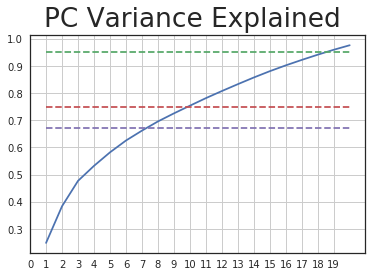

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# bin is my x axis variable
bin = []
for i in range (n_components):
    bin.append(i+1)
# plot the cummulative variance against the index of PCA
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(bin, cum_var)
# plot the 95% threshold, so we can read off count of principal components that matter
plt.plot(bin, [.95]*n_components, '--')
plt.plot(bin, [.75]*n_components, '--')
plt.plot(bin, [.67]*n_components, '--')
#turn on grid to make graph reading easier
plt.grid(True)
plt.rcParams.update({'font.size': 22})
plt.suptitle('PC Variance Explained')
# control number of tick marks
plt.xticks([i for i in range(0,n_components)])
plt.show()

# Plot Principal Components: Scatter Matrix

Scatter Matrix using PCA allows us to see patterns visually. It helps to get a better feel for where you might want to drive and exploration

Control the **colors** by the ** churn variable** or by the cluster they are in

Get a feel for clsutering beahvior

* **black = no churn**

* **red = churn**

/root/python2_env/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  del sys.path[0]


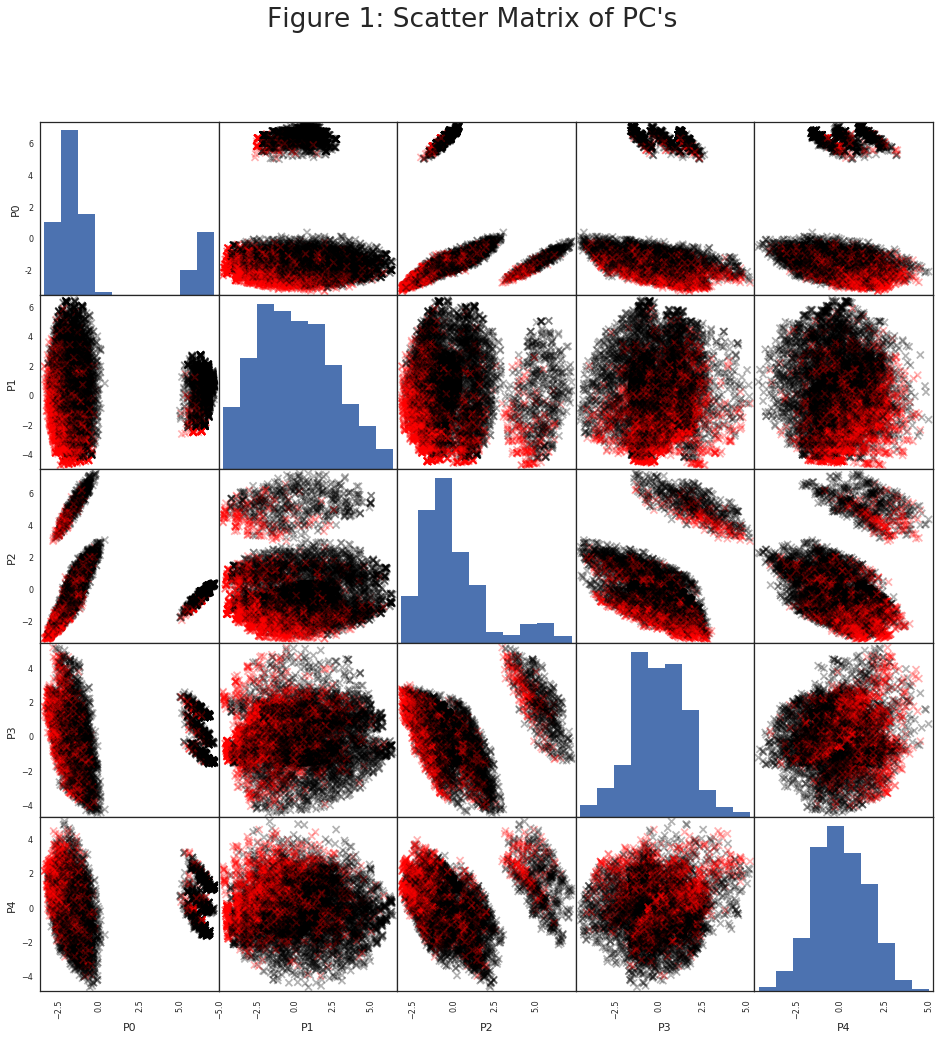

In [21]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Figure 1
# color the plot by the Churn variable
# attributes are the index of Principal components to plot against each other
attributes = ["P0", "P1", "P2", "P3", "P4"]
#attributes = [item + 10 for item in attributes]   # mthod to add if you want to look at the least significant components
churn_colors=['black', 'red']  # colors to use to plot churners
# make a scatter plot
scatter_matrix(pcomps[attributes], alpha =.3, marker='x',c=pcomps.Churn.apply(lambda x:churn_colors[x]), figsize=[16,16])
#scatter_matrix(pcomps[attributes], alpha =.3, marker='x',c=churn_cat_encode_new2.InternetService0.astype('int').apply(lambda x:churn_colors[x]), figsize=[16,16])
plt.rcParams.update({'font.size': 22})
plt.suptitle("Figure 1: Scatter Matrix of PC's")
plt.show()


## PCA notes

vertical clusters in columns such as those observed in P0 tend to not covary much with other other componets.  Clusters that align diagonally, say in plots P0 vs P4, indicate that the cluster varies with compenent 0 and 4 in a linear fashion and three bands indicates that there are three thresholds that govern the separtion of each the the three banded diagonal clusters. Coloring by our label could give us insight into which clusters to examine in more detail. For example, we can cut the tall vertical cluster in P0 out from the rest for deeper analysis.

## Method to Drill Down to Specific Portion of the Data
We are keying off the graph above and noticing that P0 < 0 covers a major portionof the clusters

So what makes this part of the tick?

In [22]:
churn_encoded_numeric[pcomps['P0']>0].describe()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn
count,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.0,...,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000
mean,0.340924,0.240729,0.418347,0.574496,0.425504,0.003253,0.003904,0.992843,0.007157,0.0,...,0.002602,0.004554,0.992843,0.488614,0.511386,0.033832,21.362850,30.576448,682.036729,0.073520
std,0.474174,0.427665,0.493448,0.494580,0.494580,0.056962,0.062378,0.084322,0.084322,0.0,...,0.050965,0.067354,0.084322,0.500033,0.500033,0.180856,4.016227,24.333368,584.748366,0.261073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,19.700000,8.000000,161.950000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,20.150000,25.000000,531.600000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,20.950000,53.000000,1124.200000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,73.600000,72.000000,4097.050000,1.000000





# One Approach to Outliers (DBSCAN Visualization)

Control the **colors** by the **cluster** they are in

Get a feel for clustering behavior

We added the cluster number to the dataframe so we can drill down as needed to examine a cluster in more detail.

When we create the model we might decide to take advantage of our feature engineering here or we might decide to let the ML/DL algorithm use all the data to make predictions.

**NOTE:** Be careful with relying on the cluster number. These were established by random selection. So each time we run we may get a different cluster number for what humans percieve as a cluster or the k-means may find different clusters entirely. Specifying a random seed or using a different cluster methods, such as self organizing maps (SOM) may make this part more robust.

It would be great if we could isolate the different communities from each other and see if this affects the churn prediction.

For dbscan, when looking for outliers, I adjust the eps value to find a way to have a small number of clusters and the Outlier cluster (index = -1) be  on the order of 1% or 2% of the total number of observations


eps:4.2 Estimated number of clusters: 3
Outliers: 117:   Estimated number of clusters: 3


churnlab_utils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[tdft]=labels


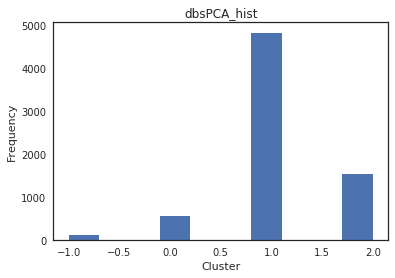

In [23]:
### import numpy as np
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

X = pcomps
eps = 4.2

number_of_eigens = 10
#subset_cols = X.columns[:10]
#pcomps2, labels, n_clusters = pdutil_dbscan(X[subset_cols], 4.2)  # call pd_dbscan with df=X, eps = 4.2

subset_cols = X.columns[:number_of_eigens] 
lst = subset_cols.tolist()

pcomps, labels, n_clusters = pdutil_dbscan(X[lst], eps)  # call pd_dbscan with df=X, eps = 4.2

dbsPCA_hist = pcomps.dbsPCA
print('Outliers: {}:   Estimated number of clusters: {}'.format(  dbsPCA_hist.tolist().count(-1),  n_clusters) )
plt.hist( dbsPCA_hist)
plt.title("dbsPCA_hist")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
#plt.axis([-1,n_clusters,0,7200])
plt.show()

## Copying the dbscan column info for convenience

In [26]:
# dbsPCA is the cluster #
if 'dbsPCA' not in churn_encoded_numeric.columns:
    churn_encoded_numeric = pd.concat([churn_encoded_numeric, pcomps['dbsPCA']], axis=1)
churn_encoded_numeric.head(30)

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,dbsPCA
0,1,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,29.85,1,29.85,0,0
1,0,1,0,1,0,0,1,0,1,0,...,0,0,0,1,0,56.95,34,1889.50,0,1
2,1,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,53.85,2,108.15,1,1
3,0,1,0,1,0,0,1,0,1,0,...,1,0,0,1,0,42.30,45,1840.75,0,0
4,1,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,70.70,2,151.65,1,1
5,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,99.65,8,820.50,1,1
6,1,0,0,0,1,1,0,0,0,1,...,0,0,0,1,0,89.10,22,1949.40,0,1
7,1,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,29.75,10,301.90,0,0
8,1,0,0,1,0,0,1,0,0,1,...,1,0,1,0,0,104.80,28,3046.05,1,1
9,0,1,0,0,1,1,0,0,1,0,...,0,0,0,1,0,56.15,62,3487.95,0,1


/root/python2_env/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  if sys.path[0] == '':


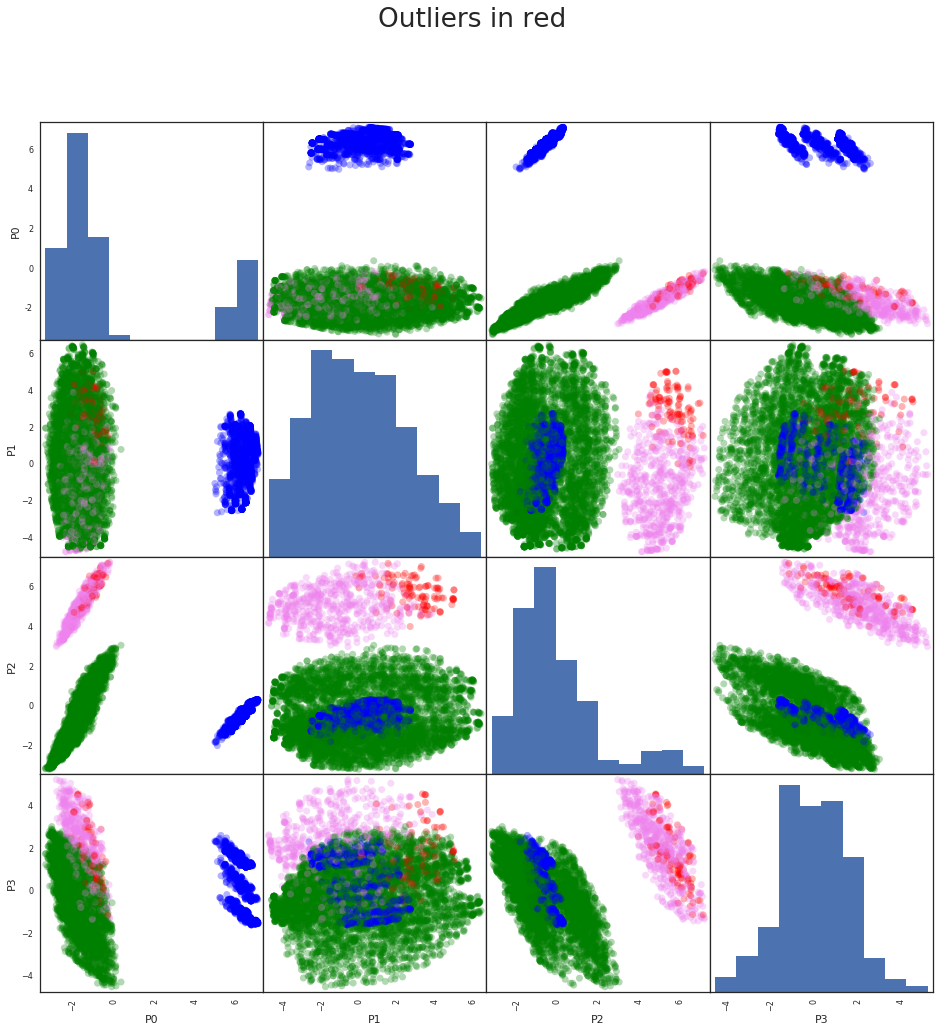

In [31]:
# Figure 2
# plot each cluster a different color so we can see what cluster number is associated with each blob
df2 = pcomps
#df2 = pcomps[pcomps['Churn'] == 1]

#control how many and order of scatter plots to compare
attributes = ["P0", "P1", "P2", "P3"]

# if we generate too many clusters we run out of colors to display them.
colors=['red', 'violet','green','blue', 'yellow', 'black', 'gray', 'white', 'orange']
#dbscan numbers clusters from -1 to some positive number, the negative ones I want to color red, I use lambda to do this
scatter_matrix(df2[attributes],figsize=[16,16],marker='o', alpha=.3, c=df2['dbsPCA'].apply(lambda x:colors[x+1]))
plt.rcParams.update({'font.size': 22})
plt.suptitle("Outliers in red")
plt.show()

In [35]:
print('Outliers: {} '.format(  dbsPCA_hist.tolist().count(-1)) )


Outliers: 117 


# Examine Outliers Statistics Like This

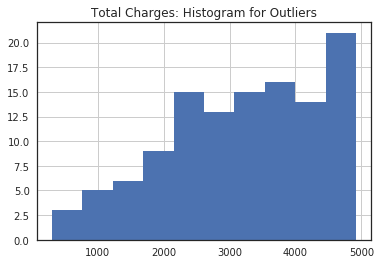

In [32]:
# Add Churn column to churn encoded data if not already there
if 'Churn' not in churn_encoded_numeric.columns:
    churn_encoded_numeric = pd.concat([churn_encoded_numeric, label], axis=1)  # add numeric to main df
churn_encoded_numeric[pcomps['dbsPCA']<0]

plt.title('Total Charges: Histogram for Outliers')
Outliers = churn_encoded_numeric[pcomps['dbsPCA']<0]['TotalCharges']
Outliers.hist()

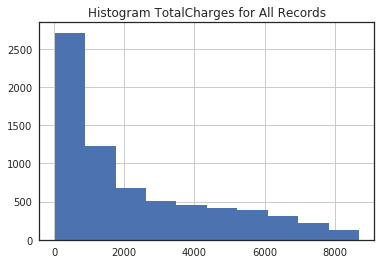

In [33]:
plt.title('Histogram TotalCharges for All Records')
GeneralPop = churn_encoded_numeric['TotalCharges']
GeneralPop.hist()

# Descriptive Statistics of Outliers

Below we shall describe the subset of the population we uncovered as outliers.

Do you see any trends? Look at each column and identify columns that have a very low or very high mean. Especially, look for columns with a mean of 0 or 1. These values indicate that the entire column has a single through every instance. Also, look for any means that differ significantly from the general population.

In [36]:

# Select just the outliers (dbsPCA == -1)  and describe this subset.  Look for items of potential interest.
#churn_encoded_numeric[churn_encoded_numeric['dbsPCA']<0].describe()
churn_encoded_numeric[pcomps['dbsPCA']<0].describe()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,dbsPCA
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.0,117.0,117.0,...,117.000000,117.0,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.0
mean,0.008547,0.282051,0.709402,0.324786,0.675214,0.170940,0.829060,0.0,1.0,0.0,...,0.829060,0.0,0.538462,0.461538,0.068376,54.902564,56.940171,3165.519235,0.008547,-1.0
std,0.092450,0.451934,0.455991,0.470309,0.470309,0.378076,0.378076,0.0,0.0,0.0,...,0.378076,0.0,0.500663,0.500663,0.253476,8.422286,17.850090,1147.878626,0.092450,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,29.900000,0.000000,305.550000,0.000000,-1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,...,1.000000,0.0,0.000000,0.000000,0.000000,49.850000,48.000000,2317.100000,0.000000,-1.0
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,1.0,0.0,...,1.000000,0.0,1.000000,0.000000,0.000000,56.400000,65.000000,3281.650000,0.000000,-1.0
75%,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,1.0,0.0,...,1.000000,0.0,1.000000,1.000000,0.000000,60.800000,71.000000,4122.650000,0.000000,-1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,0.0,...,1.000000,0.0,1.000000,1.000000,1.000000,67.200000,72.000000,4919.700000,1.000000,-1.0


# Comentary: On descriptive statitics 

When the number_of_eigens was set to 10, and the dbscan eps was set to 4.2 we arrive at one view of the churn_encoded_numeric dataframe.  In that particualr case the outliers, reflected by the dbsPCA cluster number = -1, show some interesting behavior.

Filtering the data to look at just outliers (dbsPCA = <0) exhibits interesting behaviors. Doing a describe on the data allows us to look for patterns visually. What I look for are strange mean values or strange extremes for max or min. We see that P0 < 0 pertains specifically to the class where DeviceProtection2 has a value of 0 for all instances while InternetService0 has a value of 1. Also the Total_chrages seem higher than average. So lets explore that more.

So we are capturing some commonalities that all those in the outlier class exhibit.





# Modeling

## Split Data - Training/Test

Splitting the data can be a very easy thing but its also easy to get into trouble.

We want to ensure that in subsequent runs we never contaminate the test set from run to run. Using a random seed help something like randseed = 42

But if we ever drop or add rows, and then use the same random selection we will likely wind up putting a new value into our test set inadvertantly.

It would be best to split the data based on some invariant such as a hask of column names or some other unique row identifier. But for now we take the easy random split approach.

In [37]:
# to make this notebook's output identical at every run
np.random.seed(42)
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def split_train_test2(data, labels, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices], labels.iloc[train_indices], labels.iloc[test_indices]

churn_encoded_numeric
churn_scaled = pd.concat([churn_cat['customerID'], churn_encoded_numeric], axis=1)
churn_scaled.head()
#if ( len(churn_scaled.customerID.unique()) ==  len(churn_encoded_numeric)) : print "Unique Identifier"



,customerID,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,...,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,dbsPCA
0,7590-VHVEG,1,0,0,1,0,1,0,0,1,...,0,0,1,0,0,29.85,1,29.85,0,0
1,5575-GNVDE,0,1,0,1,0,0,1,0,1,...,0,0,0,1,0,56.95,34,1889.50,0,1
2,3668-QPYBK,1,0,0,1,0,1,0,0,1,...,0,0,0,1,0,53.85,2,108.15,1,1
3,7795-CFOCW,0,1,0,1,0,0,1,0,1,...,1,0,0,1,0,42.30,45,1840.75,0,0
4,9237-HQITU,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,70.70,2,151.65,1,1


# First Model - Decision Tree

Use churn_scaled dataframe which is a more minimally processed version of our raw data - all numeric, but no pca at this point.

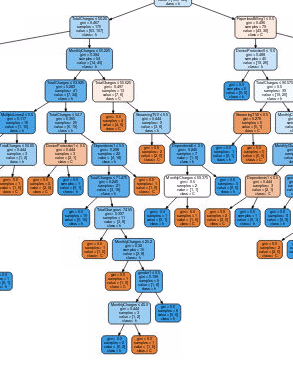

In [38]:
X = churn_encoded_numeric
train_set, test_set = split_train_test(X, 0.2)

accuracy: 0.796164772727


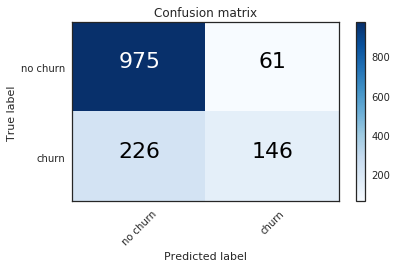

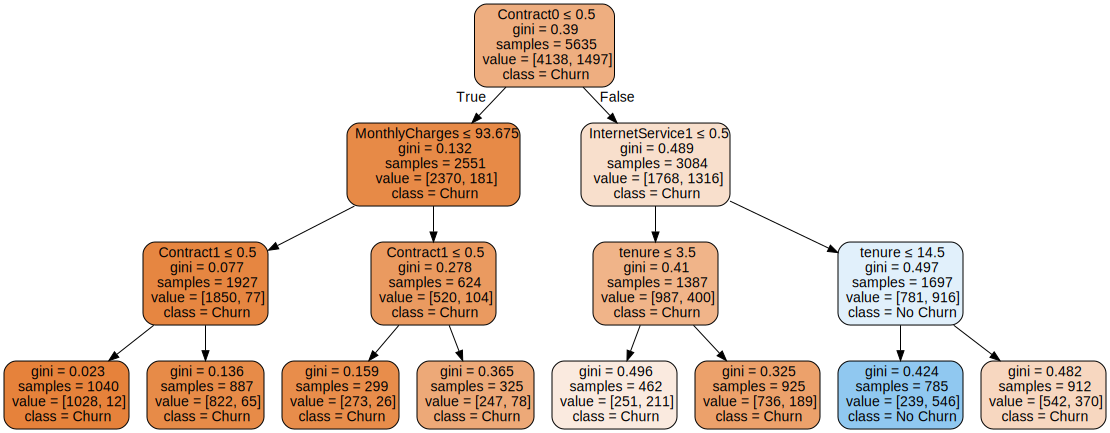

In [39]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz
from sklearn.metrics import confusion_matrix

clf = DecisionTreeClassifier(random_state=42, max_depth = 3)
AllCols = X.columns
StaticCols = ['Churn','dbsPCA']

dataCols = (list(set(AllCols) - set(StaticCols)))
clf = clf.fit(train_set[dataCols], train_set['Churn'])
#accuracy = cross_val_score(clf, churn_cat_encode_new2[dataCols], churn_cat_encode_new2['Churn'], cv=10)
predicted = clf.predict(test_set[dataCols])
print "accuracy: {}".format(accuracy_score(test_set['Churn'], predicted ) )

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=dataCols,  
                         class_names=['Churn','No Churn'],
                         filled=True, rounded=True,  
                         special_characters=True) 
#graph.render("Churn")   #to copy to pdf
graph = graphviz.Source(dot_data) 
graph.render("TreeModel")
graph   #churners orange, non chutners blue


class_names = ['no churn','churn']    
cnf_matrix = confusion_matrix(test_set['Churn'], predicted)

plot_confusion_matrix(cnf_matrix, class_names)

graph

# Comprehending the diagram
Follow the tree from the top and modify the query below to match the cloumns/conditions you observe in the tree

This shoudl give you a sense of how you can filter your data to observe behaviors associated with the most concentrated pockets of Churners (orange) or Non Churners (blue) in the case.

If you want to increase your odds of determining the parameters that non-churners like most direct your query more to the dark blue leaf nodes. To experiment with high likelihood churners point your attention to the darkest orange boxes.

In [40]:
q = (train_set['Contract0'] <= 0.5) & (train_set['MonthlyCharges'] <=93.675) & (train_set['Contract1'] <= 0.5)
print "{}\ttotal number of customers in this sub population".format(len(train_set[q]))
print "{}\t\tChurners in this sub population".format( (train_set[q]['Churn']==1).sum() )
print "{}\t\tNon churners in this sub population".format( (train_set[q]['Churn'] < 1).sum() )

1040	total number of customers in this sub population
12		Churners in this sub population
1028		Non churners in this sub population


# Second Model Neural Network in Tensofrflow (Fully Connected Layers)

Now we can begin exploring using Tensorflow to model a Deep Neural Network of fully connected layers as a churn classifier. Little effort has been applied to select the best hyperparameters here. This netork is using ONLY the categorical values becuase including MonthlyCharges and TotalCharges lowers the accuracy.  Perhaps binning these continuous variables is an option or perhaps using the standardized data across the board with a different loss function would be next steps to try.

The code below prepares the training and test data sets and specifies, for now, to use only the categorical columns without MonthlyCharges/TotalCharges. It then converts the requiresite data to numpy arrays.

In [ ]:

X = churn_encoded_numeric.apply(np.int32)
AllCols = X.columns
# remove the numeric columns, to see how accurately just categorical columns predict
# remove Churn because that is waht we are trying to predict
StaticCols = ['Churn','MonthlyCharges','TotalCharges']
dataCols = sorted(list(set(AllCols) - set(StaticCols)))

CLASS_SIZE = 2
DATA_SIZE = len(dataCols)

xdata, xtest  = split_train_test( X, 0.2)
y_data = np.array(xdata['Churn'])
y_test = np.array(xtest['Churn'])
x_data = np.array(xdata[dataCols])
x_test = np.array(xtest[dataCols])

#x_data, x_test, y_data, y_test = split_train_test2( X[dataCols], X['Churn'], 0.2)

x_train = np.array(x_data)
y_train = np.array(y_data)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Creating and running fully connected Tensorflow NN.

The code below creates the Tensorflow graph with three hidden fully connected layers and trains the model with classifier.fit and makes predictions with classifier.predict (for details of the code used to do this see the churnlab_utils.py code). 

We then display a matrix showing how our predictions and mispredictions faired against actual values (Data Scientists call this a confusion matrix). It gives us insight into how well the model predicts or mispredicts. In a perfect world with 100% prediction - the main diagonal would have all the values and the off diagonal would be both zeros.  The extent to which we miss this ideal indicates how and in what manner our predictions were off. To the extent that we precietd 'No Churn' but actually experienced churn we would see larger than zero value in the lower left hand side.  In a similar way, positive values in the upper right indicate the extent to which we predicted Churn when there was no churn in actuality.


In [ ]:
from sklearn.metrics import confusion_matrix

# Build 3 layer DNN with 10, 30, 10 units respectively.
classifier = Classifier(hidden_units=[10,30,10], n_classes = 2, data_size = len(dataCols))

# Fit model. steps=1200
classifier.fit(x_train, y_train, steps=1200)

# Evaluate accuracy.
accuracy_score = classifier.evaluate(x_test, y_test)[0]
print('Accuracy: {0:f}'.format(accuracy_score))

# Classify two new flower samples.
y_pred = classifier.predict(x_test)
#print (y > .5).sum()
print ('Predictions: {}'.format(str(y_pred)))

class_names = ['no churn','churn']    
cnf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cnf_matrix, class_names)